In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data
The data were drawn from https://ourworldindata.org/ which were in turn drawn from various official Greek sources.
Their coronavirus dataset is freely available in https://github.com/owid/covid-19-data/tree/master/public/data.

In [2]:
!rm ./owid-covid-data.csv
!wget https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv

--2021-01-28 02:52:26--  https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.16.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.16.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15989825 (15M) [text/plain]
Saving to: ‘owid-covid-data.csv’

owid-covid-data.csv 100%[===================>]  15,25M  3,69MB/s    in 7,7s    

2021-01-28 02:52:40 (1,99 MB/s) - ‘owid-covid-data.csv’ saved [15989825/15989825]



# Take a look at the dataset

In [3]:
path = "owid-covid-data.csv"
df = pd.read_csv(path)
df.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'new_vaccinations',
       'new_vaccinations_smoothed', 'total_vaccinations_per_hun

In [4]:
gr = df.loc[ df["location"] == "Greece" ]

In [5]:
with pd.option_context('display.max_rows', 50, 'display.max_columns', 60):
    display(gr)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
21840,GRC,Europe,Greece,2020-02-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,10423056.0,83.479,45.3,20.396,14.524,24574.382,1.5,175.695,4.55,35.3,52.0,NaN,4.21,82.24,0.87
21841,GRC,Europe,Greece,2020-02-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,10423056.0,83.479,45.3,20.396,14.524,24574.382,1.5,175.695,4.55,35.3,52.0,NaN,4.21,82.24,0.87
21842,GRC,Europe,Greece,2020-02-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,10423056.0,83.479,45.3,20.396,14.524,24574.382,1.5,175.695,4.55,35.3,52.0,NaN,4.21,82.24,0.87
21843,GRC,Europe,Greece,2020-02-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,10423056.0,83.479,45.3,20.396,14.524,24574.382,1.5,175.695,4.55,35.3,52.0,NaN,4.21,82.24,0.87
21844,GRC,Europe,Greece,2020-02-26,1.0,1.0,NaN,NaN,NaN,NaN,0.096,0.096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.11,10423056.0,83.479,45.3,20.396,14.524,24574.382,1.5,175.695,4.55,35.3,52.0,NaN,4.21,82.24,0.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22176,GRC,Europe,Greece,2021-01-23,151646.0,605.0,468.000,5622.0,24.0,25.857,14549.092,58.044,44.900,539.381,2.303,2.481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3961627.0,30996.0,380.083,2.974,24841.0,2.383,0.019,53.1,samples tested,157388.0,154273.0,3115.0,16518.0,11092.0,1.51,1.48,0.03,1064.0,80.56,10423056.0,83.479,45.3,20.396,14.524,24574.382,1.5,175.695,4.55,35.3,52.0,NaN,4.21,82.24,0.87
22177,GRC,Europe,Greece,2021-01-24,151980.0,334.0,481.857,5646.0,24.0,25.286,14581.136,32.044,46.230,541.684,2.303,2.426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3973500.0,11873.0,381.222,1.139,24995.0,2.398,0.019,51.9,samples tested,NaN,NaN,NaN,NaN,12128.0,NaN,NaN,NaN,1164.0,80.56,10423056.0,83.479,45.3,20.396,14.524,24574.382,1.5,175.695,4.55,35.3,52.0,NaN,4.21,82.24,0.87
22178,GRC,Europe,Greece,2021-01-25,152412.0,432.0,498.143,5671.0,25.0,26.143,14622.583,41.447,47.792,544.082,2.399,2.508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3982894.0,9394.0,382.123,0.901,25169.0,2.415,0.020,50.5,samples tested,177377.0,169456.0,7921.0,NaN,13165.0,1.70,1.63,0.08,1263.0,NaN,10423056.0,83.479,45.3,20.396,14.524,24574.382,1.5,175.695,4.55,35.3,52.0,NaN,4.21,82.

In [6]:
with pd.option_context('display.max_rows', 50, 'display.max_columns', 60):
    display(gr[["location", "date", "new_tests", "total_tests", "new_cases_smoothed", "icu_patients", "icu_patients_per_million", "hosp_patients"]]) #need display to show the dataframe when using with in jupyter

,location,date,new_tests,total_tests,new_cases_smoothed,icu_patients,icu_patients_per_million,hosp_patients
21840,Greece,2020-02-02,NaN,NaN,NaN,NaN,NaN,NaN
21841,Greece,2020-02-09,NaN,NaN,NaN,NaN,NaN,NaN
21842,Greece,2020-02-15,NaN,NaN,NaN,NaN,NaN,NaN
21843,Greece,2020-02-23,NaN,NaN,NaN,NaN,NaN,NaN
21844,Greece,2020-02-26,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
22176,Greece,2021-01-23,30996.0,3961627.0,468.000,NaN,NaN,NaN
22177,Greece,2021-01-24,11873.0,3973500.0,481.857,NaN,NaN,NaN
22178,Greece,2021-01-25,9394.0,3982894.0,498.143,NaN,NaN,NaN
22179,Greece,2021-01-26,36240.0,4019134.0,537.714,NaN,NaN,NaN


In [7]:
inf_gr = gr[["date", "new_tests", "total_tests", "new_cases", "icu_patients", "icu_patients_per_million", "hosp_patients"]].copy()
inf_gr = inf_gr.reset_index(drop=True)
inf_gr["date"] = pd.to_datetime( inf_gr["date"], dayfirst=False)

# Inference
There appear to be missing data both in the "new_tests" columns and in the "total_tests" columns. We use the "total_tests" column to infer "new_tests". Between two dates that do have a report of the cumulative number of tests, we assume a uniform distribution of the difference of the tests between those two dates.

In [8]:
num_tests = [] 
k = 0
last = 0
s = 0
for total in inf_gr["total_tests"]:
    if np.isnan(total):
        k += 1
    else:
        k += 1
        new = []
        new = [ (total - last) /(k) ] * (k)
        s += ((total - last) /(k)) * k
        num_tests.extend(new)
        last = total
        k = 0
if k != 0:
    num_tests.extend([np.nan]*k)

In [9]:
len(inf_gr["new_tests"])

341

In [10]:
inf_gr["new_tests"] = num_tests

In [11]:
import numpy as np
from scipy.signal import find_peaks

tests = np.array(num_tests)
argpeaks, _ = find_peaks(tests, height=30000)
peaks = tests[argpeaks]
print("Extreme peaks were found for the dates:")
print(inf_gr["date"].array[argpeaks])

Extreme peaks were found for the dates:
<DatetimeArray>
['2020-07-29 00:00:00', '2020-08-04 00:00:00', '2020-08-19 00:00:00',
 '2020-11-18 00:00:00', '2020-11-20 00:00:00', '2020-11-26 00:00:00',
 '2020-12-01 00:00:00', '2020-12-11 00:00:00', '2020-12-16 00:00:00',
 '2020-12-18 00:00:00', '2020-12-22 00:00:00', '2020-12-30 00:00:00',
 '2021-01-05 00:00:00', '2021-01-09 00:00:00', '2021-01-12 00:00:00',
 '2021-01-14 00:00:00', '2021-01-19 00:00:00', '2021-01-22 00:00:00']
Length: 18, dtype: datetime64[ns]


In [12]:
inf_gr["date"][argpeaks]

158   2020-07-29
164   2020-08-04
179   2020-08-19
270   2020-11-18
272   2020-11-20
278   2020-11-26
283   2020-12-01
293   2020-12-11
298   2020-12-16
300   2020-12-18
304   2020-12-22
312   2020-12-30
318   2021-01-05
322   2021-01-09
325   2021-01-12
327   2021-01-14
332   2021-01-19
335   2021-01-22
Name: date, dtype: datetime64[ns]

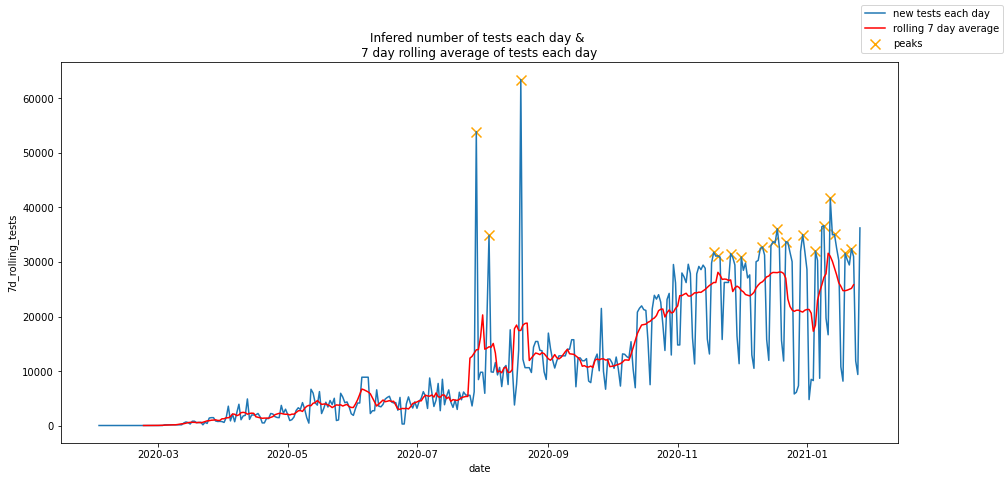

In [13]:
fig, ax = plt.subplots(figsize=(15,7))
g = sns.lineplot(data=inf_gr, x="date", y="new_tests")
# g.set(xticks=[ i for i in range(len(inf_gr)) if i%30==0] )
g.scatter(inf_gr["date"][argpeaks], peaks, marker='x', color='orange', s=100)
plt.title("Infered number of tests each day & \n7 day rolling average of tests each day")

inf_gr ["7d_rolling_tests"] = inf_gr.new_tests.rolling(7).mean().shift(-3)

g = sns.lineplot(data=inf_gr, x="date", y="7d_rolling_tests", color='red', ax=ax)
ax.figure.legend(["new tests each day", "rolling 7 day average", "peaks"])

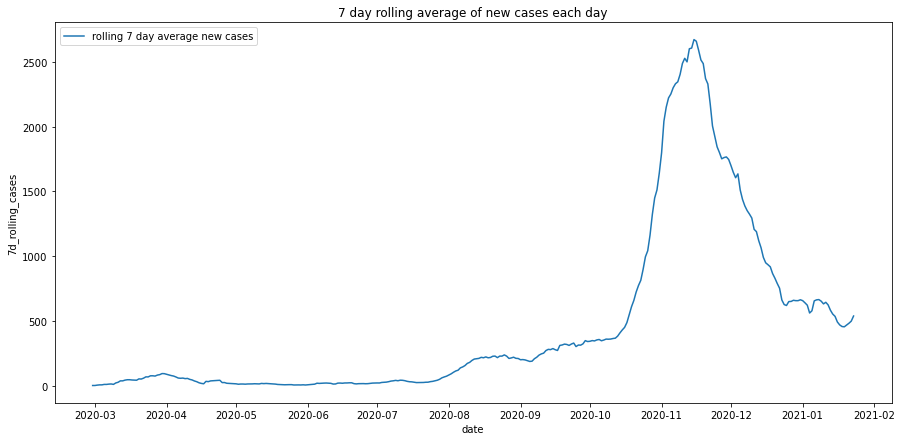

In [14]:
inf_gr ["7d_rolling_cases"] = inf_gr.new_cases.rolling(7).mean().shift(-3)
plt.figure(figsize=(15,7))

g = sns.lineplot(data=inf_gr, x="date", y="7d_rolling_cases")
# g.set(xticks=[ i for i in range(len(inf_gr)) if i%30==0] )
plt.title("7 day rolling average of new cases each day")
g.legend(["rolling 7 day average new cases"])

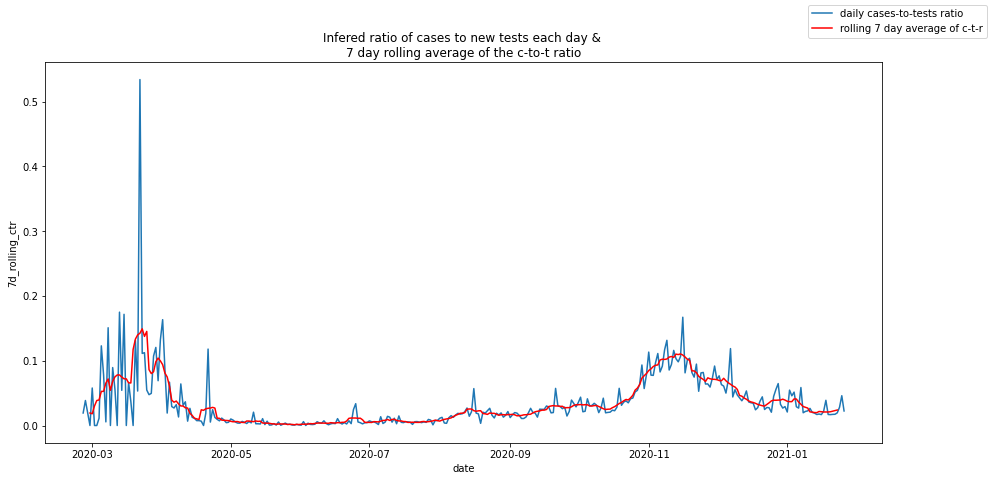

In [15]:
inf_gr["cases_tests_ratio"] = np.array(inf_gr["new_cases"].array) / np.array(inf_gr["new_tests"].array)


fig, ax = plt.subplots(figsize=(15,7))
g = sns.lineplot(data=inf_gr, x="date", y="cases_tests_ratio")
# g.set(xticks=[ i for i in range(len(inf_gr)) if i%30==0] )
plt.title("Infered ratio of cases to new tests each day & \n7 day rolling average of the c-to-t ratio")

inf_gr ["7d_rolling_ctr"] = inf_gr.cases_tests_ratio.rolling(7).mean().shift(-3)

g = sns.lineplot(data=inf_gr, x="date", y="7d_rolling_ctr", color='red', ax=ax)
ax.figure.legend(["daily cases-to-tests ratio", "rolling 7 day average of c-t-r"])


# Visualizing curves with different range
In order to visualize the curves of "new tests" and "case-to-test ratio" and the curves of "7 day rolling average of tests" and "7 day rolling average of case-to-test ratio" in a way that would make comparison rather easy use two vertical axes, one on the left and one on the right.

Text(0.5, 1.0, 'Ratio of tests to new cases each day over new daily new tests')

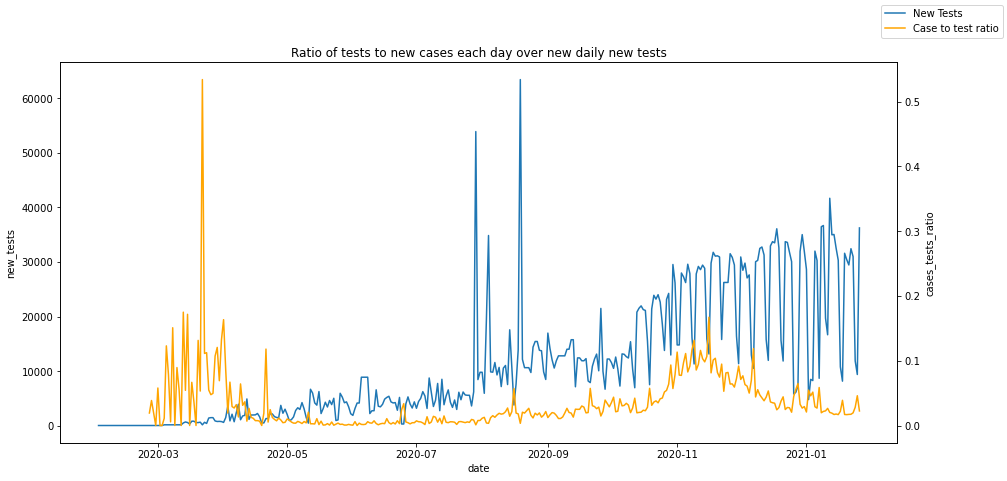

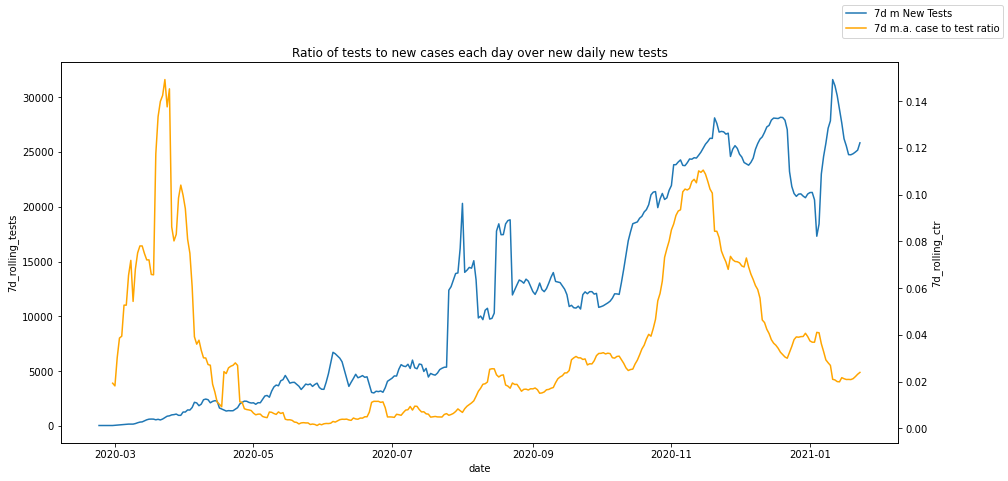

In [16]:
fig, ax = plt.subplots(figsize=(15,7))
g = sns.lineplot(data=inf_gr, x="date", y="new_tests", ax=ax)
ax_r = ax.twinx()
g = sns.lineplot(data=inf_gr, x="date", y="cases_tests_ratio", color="orange", ax=ax_r)
ax.figure.legend(["New Tests", "Case to test ratio"])
plt.title("Ratio of tests to new cases each day over new daily new tests")

## moving average
s
fig, ax = plt.subplots(figsize=(15,7))
g = sns.lineplot(data=inf_gr, x="date", y="7d_rolling_tests", ax=ax)
ax_r = ax.twinx()
g = sns.lineplot(data=inf_gr, x="date", y="7d_rolling_ctr", color="orange", ax=ax_r, legend=False)
ax.figure.legend(["7d m New Tests", "7d m.a. case to test ratio"])
plt.title("Ratio of tests to new cases each day over new daily new tests")

Text(0.5, 1.0, 'Ratio of tests to new cases each day over new daily new tests')

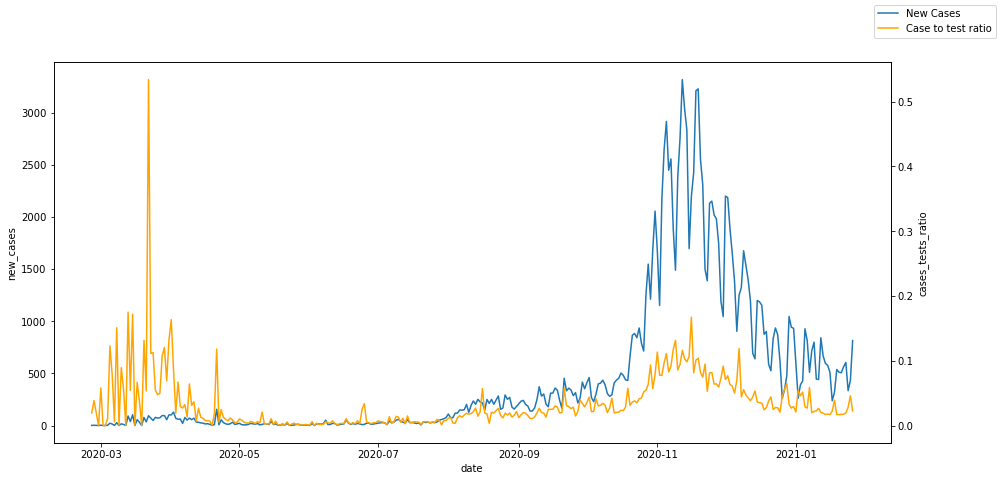

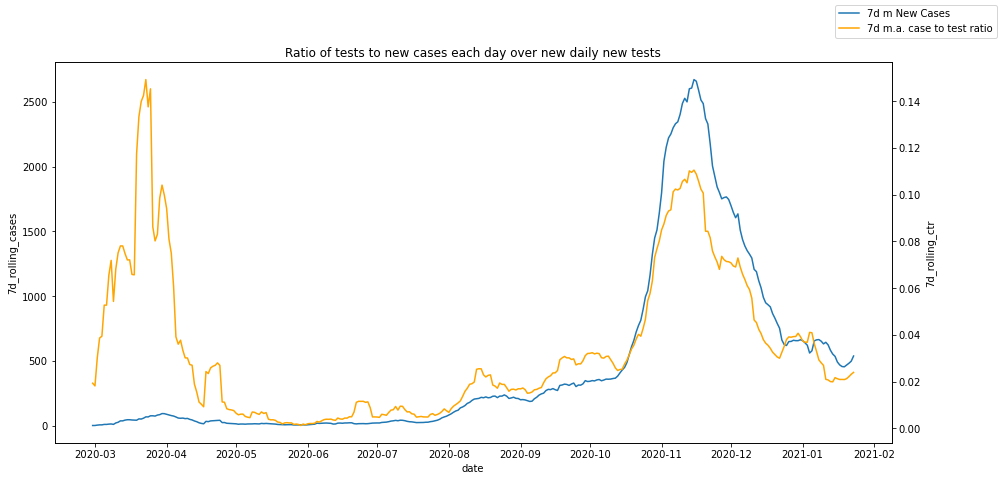

In [17]:
fig, ax = plt.subplots(figsize=(15,7))
g = sns.lineplot(data=inf_gr, x="date", y="new_cases", ax=ax)
ax_r = ax.twinx()
sns.lineplot(data=inf_gr, x="date", y="cases_tests_ratio",color="orange", ax=ax_r)
ax.figure.legend(["New Cases", "Case to test ratio"])

## moving average

fig, ax = plt.subplots(figsize=(15,7))
g = sns.lineplot(data=inf_gr, x="date", y="7d_rolling_cases", ax=ax)
ax_r = ax.twinx()
sns.lineplot(data=inf_gr, x="date", y="7d_rolling_ctr", color="orange", ax=ax_r)
ax.figure.legend(["7d m New Cases", "7d m.a. case to test ratio"])
plt.title("Ratio of tests to new cases each day over new daily new tests")

In [18]:
# Missing reports on ICU patients & Hospitalized patients
print("Number of missing values on ICU patients:\t\t", np.sum(np.isnan(inf_gr["icu_patients"]) ))
print("Number of missing values on ICU patients/mil:\t\t", np.sum(np.isnan(inf_gr["icu_patients_per_million"])) )
print("Number of missing values on Hospitalized Patients:\t", np.sum( np.isnan(inf_gr["hosp_patients"])))

Number of missing values on ICU patients:		 341
Number of missing values on ICU patients/mil:		 341
Number of missing values on Hospitalized Patients:	 341
